# **Import Libraries**

In [1]:
# Colab Requirements
# !pip install spectral
# from google.colab import drive, files
# drive.mount('/content/drive')
## Basics
import gc
gc.collect()
import warnings
warnings.filterwarnings('ignore')
import time
# import numpy 
import numpy as np
# import pandas as pd
from PIL import Image
from operator import truediv
import scipy.io as sio
import os
# import seaborn as sns
## Ploting
# from plotly.offline import iplot, init_notebook_mode
# import plotly.graph_objs as go
from matplotlib.pyplot import cm
import matplotlib.pyplot as plt
# init_notebook_mode(connected=True)
# %matplotlib inline
## Sklearn 
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
## Dimensionality Reduction Methods
from sklearn.decomposition import PCA, IncrementalPCA, KernelPCA, SparsePCA, TruncatedSVD
## Deep Model
import keras, h5py
from keras.layers import Input, Conv2D, Conv3D, Flatten, Dense, Reshape, Dropout
#from plotly.offline import iplot, init_notebook_mode
from keras.losses import categorical_crossentropy
from keras.models import Sequential, Model
from keras.utils import np_utils
import tensorflow as tf
from tensorflow.keras import models, layers
from keras.utils.vis_utils import plot_model
import keras
from tensorflow.keras.optimizers import Adam
import spectral.io.envi as envi

# **Loading Hyperspectral Datasets**

In [2]:
## Get HSI Data and Ground Truths
## Get HSI Data
path='../Datasets/HyperBlood/'
def get_data(name,remove_bands=True,clean=True, path=path):
    """
    Input: name: name; remove_bands: if True, noisy bands are removed (leaving 113 bands)
    clean: if True, remove damaged line
    Output: data, wavelenghts as numpy arrays (float32)
    """
    name = convert_name(name)
    filename = "{}data/{}".format(path,name)
    hsimage = envi.open('{}.hdr'.format(filename),'{}.float'.format(filename))
    wavs = np.asarray(hsimage.bands.centers) 
    data = np.asarray(hsimage[:,:,:],dtype=np.float32)
    #removal of damaged sensor line
    if clean and name!='F_2k':
        data = np.delete(data,445,0)
    if not remove_bands:
        return data,wavs
    return data[:,:,get_good_indices(name)],wavs[get_good_indices(name)]

## Get Ground Truths
def get_anno(name,remove_uncertain_blood=True,clean=True, path=path):
    """
    Returns annotation (GT) for data files as 2D int numpy array
    Classes: 0 - background; 1 - blood; 2 - ketchup; 3 - artificial blood; 4 - beetroot juice
    5 - poster paint; 6 - tomato concentrate; 7 - acrtylic paint; 8 - uncertain blood;
    Input: name: name; clean: if True, remove damaged line; 
    remove_uncertain_blood: if True, removes class 8 
    Output: annotation as numpy 2D array 
    """
    name = convert_name(name)
    filename = "{}anno/{}".format(path,name)
    anno = np.load(filename+'.npz')['gt']
    #removal of damaged sensor line
    if clean and name!='F_2k':
        anno = np.delete(anno,445,0)
    #remove uncertain blood + technical classes
    if remove_uncertain_blood:
        anno[anno>7]=0
    else:
        anno[anno>8]=0
    return anno


def blood_loader(path, name):
    """
    returns data and annotation, removing classes that are not present in all images
    Input: path: data path; name: image name
    Output:img: data cube; gt: annotation with correct classes; 
    rgb_bands: three bands used for rgb visualisation
    ignored_labels: labels that should be ignored [0 for background] 
    label_values: class labels
    """
    img = np.asarray(get_data(name, path=path)[0], dtype='float32')
    gt = get_anno(name, path=path).astype('uint8')
    # remove beetroot juice (is only on frames images so in our
    # classification experiments we removed it from pictures)
    gt = np.where(gt == 4, 0, gt)
    # renumbering after removing beetroot juice
    for element in [5, 6, 7]:
        gt = np.where(gt == element, element - 1, gt)
    label_values = ["unclassified",
                    "blood",
                    "ketchup",
                    "artificial blood",
                    "poster paint",
                    "tomato concentrate",
                    "acrylic paint"]
    rgb_bands, ignored_labels = (47, 31, 15), [0]
    return img, gt, rgb_bands, ignored_labels, label_values

In [3]:
def convert_name(name):
    """
    Ensures that the name is in the filename format
    Parameters: name: name
    Output: cleaned name
    """
    name = name.replace('(','_')
    name = name.replace(')','')
    return name

def get_good_indices(name=None):
    """
    Input: name: name
    Output: numpy array of good indices         
    """
    name = convert_name(name)
    if name!='F_2k':
        indices = np.arange(128)
        indices = indices[5:-7]
    else:
        indices = np.arange(116)    
    indices=np.delete(indices,[43,44,45])
    return indices

In [4]:
## Load HSI Dataset
def LoadHSIData(method):
    ## List of HSI Dataasets
    HSI_list = ['A_1.hdr', 'B_1.hdr', 'C_1.hdr', 'D_1.hdr', 'E_1.hdr', 'E_7.hdr', 
                'E_21.hdr', 'F_1.hdr.hdr', 'F_1a.hdr', 'F_1s.hdr', 'F_2.hdr', 
                'F_2k.hdr', 'F_7.hdr', 'F_21.hdr']
    Num_Classes=7            
    for i in range(len(HSI_list)):
        file_name = HSI_list[i].split('.')[0]
        data_path = os.path.join(os.getcwd(),'../Datasets/HyperBlood/data'+str(file_name))
        # print(data_path)
        if os.path.exists(data_path) == False:
            # print("Data file from %s to %s" % (HSI_list[i], data_path))
            # #urllib.request.urlretrieve(url=HSI_url[i], filename=data_path)
            print(str(file_name)+" is Successfully Found")
        else:
            print(str(file_name) + " already exist")
    data_path = os.path.join(os.getcwd(),'../Datasets/HyperBlood/data')
    data_path1 = os.path.join(os.getcwd(),'../MyDrive/Datasets/HyperBlood/anno')
    if method == 'A_1':
        HSI = np.asarray(get_data(method, data_path)[0], dtype='float32')
        GT = get_anno(method, data_path1).astype('uint8')
    elif method == 'B_1':
        HSI = np.asarray(get_data(method, data_path)[0], dtype='float32')
        GT = get_anno(method, data_path1).astype('uint8')
    elif method == 'C_1':
        HSI = np.asarray(get_data(method, data_path)[0], dtype='float32')
        GT = get_anno(method, data_path1).astype('uint8')
    elif method == 'D_1':
        HSI = np.asarray(get_data(method, data_path)[0], dtype='float32')
        GT = get_anno(method, data_path1).astype('uint8')    
    elif method == 'E_1':
        HSI = np.asarray(get_data(method, data_path)[0], dtype='float32')
        GT = get_anno(method, data_path1).astype('uint8')
    elif method == 'E_7':
        HSI = np.asarray(get_data(method, data_path)[0], dtype='float32')
        GT = get_anno(method, data_path1).astype('uint8')
    elif method == 'E_21':
        HSI = np.asarray(get_data(method, data_path)[0], dtype='float32')
        GT = get_anno(method, data_path1).astype('uint8')
    elif method == 'F_1':
        HSI = np.asarray(get_data(method, data_path)[0], dtype='float32')
        GT = get_anno(method, data_path1).astype('uint8')
    elif method == 'F_1a':
        HSI = np.asarray(get_data(method, data_path)[0], dtype='float32')
        GT = get_anno(method, data_path1).astype('uint8')
    elif method == 'F_1s':
        HSI = np.asarray(get_data(method, data_path)[0], dtype='float32')
        GT = get_anno(method, data_path1).astype('uint8')
    elif method == 'F_2':
        HSI = np.asarray(get_data(method, data_path)[0], dtype='float32')
        GT = get_anno(method, data_path1).astype('uint8')
    elif method == 'F_2k':
        HSI = np.asarray(get_data(method, data_path)[0], dtype='float32')
        GT = get_anno(method, data_path1).astype('uint8')  
    elif method == 'F_7':
        HSI = np.asarray(get_data(method, data_path)[0], dtype='float32')
        GT = get_anno(method, data_path1).astype('uint8')
    elif method == 'F_21':
        HSI = np.asarray(get_data(method, data_path)[0], dtype='float32')
        GT = get_anno(method, data_path1).astype('uint8') 
    # remove beetroot juice (is only on frames images so in our
    # classification experiments we removed it from pictures)
    # GT = np.where(GT == 4, 0, GT)
    # # renumbering after removing beetroot juice
    # for element in [5, 6, 7]:
    #     GT = np.where(GT == element, element - 1, GT)
    # rgb_bands, ignored_labels = (47, 31, 15), [0]

    return HSI, GT, Num_Classes

# **Dimension Reduction Methods**

In [5]:
## Dimension Reduction
def DLMethod(method, HSI, NC = 75):
    RHSI = np.reshape(HSI, (-1, HSI.shape[2]))
    if method == 'PCA': ## PCA
        pca = PCA(n_components = NC, whiten = True)
        RHSI = pca.fit_transform(RHSI)
        RHSI = np.reshape(RHSI, (HSI.shape[0], HSI.shape[1], NC))
    elif method == 'iPCA': ## Incremental PCA
        n_batches = 256
        inc_pca = IncrementalPCA(n_components = NC)
        for X_batch in np.array_split(RHSI, n_batches):
            inc_pca.partial_fit(X_batch)
        X_ipca = inc_pca.transform(RHSI)
        RHSI = np.reshape(X_ipca, (HSI.shape[0], HSI.shape[1], NC))
    elif method == 'KPCA': ## Kernel PCA
        kpca = KernelPCA(kernel = "rbf", n_components = NC, gamma = None, 
                         fit_inverse_transform = True, random_state = 2019, 
                         n_jobs=1)
        kpca.fit(RHSI)
        RHSI = kpca.transform(RHSI)
        RHSI = np.reshape(RHSI, (HSI.shape[0], HSI.shape[1], NC))
    elif method == 'SPCA': ## Sparse PCA
        sparsepca = SparsePCA(n_components = NC, alpha=0.0001, random_state=2019, n_jobs=-1)
        sparsepca.fit(RHSI)
        RHSI = sparsepca.transform(RHSI)
        RHSI = np.reshape(RHSI, (HSI.shape[0], HSI.shape[1], NC))
    elif method == 'SVD': ## Singular Value Decomposition
        SVD_ = TruncatedSVD(n_components = NC,algorithm = 'randomized', 
                            random_state = 2019, n_iter=5)
        SVD_.fit(RHSI)
        RHSI = SVD_.transform(RHSI)
        RHSI = np.reshape(RHSI, (HSI.shape[0], HSI.shape[1], NC))
    return RHSI

# **Label Smoothing**

In [6]:
## Label Smoothing
def Smoothing(y_true, y_pred):
    return tf.keras.losses.binary_crossentropy(y_true, y_pred, label_smoothing=0.1)

def label_smoothing(y, smooth_factor):
    assert len(y.shape) == 2
    if 0 <= smooth_factor <= 1:
        y *= 1 - smooth_factor
        y += smooth_factor / y.shape[1]
    else:
        raise Exception(
            'Invalid label smoothing factor: ' + str(smooth_factor))
    return y

# **Train Test Split**

In [7]:
## Train/Test Split
def TrTeSplit(HSI, GT, testRatio, randomState=345):
    Tr, Te, TrC, TeC = train_test_split(HSI, GT, test_size = testRatio, 
                                        random_state = randomState,
                                        stratify = GT)
    return Tr, Te, TrC, TeC

# **Patches and Padding**

In [8]:
## 3-D HSI slices
def ImageCubes(HSI, GT, WS = 5, removeZeroLabels = True):
    margin = int((WS - 1) / 2)
    zeroPaddedX = ZeroPad(HSI, margin = margin)
    ## split patches
    patchesData = np.zeros((HSI.shape[0] * HSI.shape[1], WS, WS, HSI.shape[2]))
    patchesLabels = np.zeros((HSI.shape[0] * HSI.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = GT[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels
    
## Padding around HSI
def ZeroPad(HSI, margin = 2):
    NHSI = np.zeros((HSI.shape[0] + 2 * margin, HSI.shape[1] + 2* margin, HSI.shape[2]))
    x_offset = margin
    y_offset = margin
    NHSI[x_offset:HSI.shape[0] + x_offset, y_offset:HSI.shape[1] + y_offset, :] = HSI
    return NHSI

## Compute the Patch to Prepare for Ground Truths
def Patch(HSI,height_index,width_index):
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = HSI[height_slice, width_slice, :]
    return patch

# **Computing Accuracy**

In [9]:
## Classification Reports
def ClassificationReports(TeC, Te_Pred):
    Te_Pred = np.argmax(Te_Pred, axis=1)
    target_names = ["blood",
                    "ketchup",
                    "artificial blood",
                    "poster paint",
                    "tomato concentrate",
                    "acrylic paint"]
    classification = classification_report(np.argmax(TeC, axis=1), Te_Pred, target_names = target_names)
    oa = accuracy_score(np.argmax(TeC, axis=1), Te_Pred)
    confusion = confusion_matrix(np.argmax(TeC, axis=1), Te_Pred)
    list_diag = np.diag(confusion)
    list_raw_sum = np.sum(confusion, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    aa = np.mean(each_acc)
    kappa = cohen_kappa_score(np.argmax(TeC, axis=1), Te_Pred)
    return classification, confusion, oa*100, each_acc*100, aa*100, kappa*100, target_names

## Writing Results in CSV files
def CSVResults(file_name, classification, confusion, Tr_Time, Te_Time, DL_Time, kappa, oa, aa, each_acc):
    classification = str(classification)
    confusion = str(confusion)
    with open(file_name, 'w') as CSV_file:
        CSV_file.write('{} Tr_Time'.format(Tr_Time))
        CSV_file.write('\n')
        CSV_file.write('{} Te_Time'.format(Te_Time))
        CSV_file.write('\n')
        CSV_file.write('{} DL_Time'.format(DL_Time))
        CSV_file.write('\n')
        CSV_file.write('{} Kappa accuracy (%)'.format(kappa))
        CSV_file.write('\n')
        CSV_file.write('{} Overall accuracy (%)'.format(oa))
        CSV_file.write('\n')
        CSV_file.write('{} Average accuracy (%)'.format(aa))
        CSV_file.write('\n')
        CSV_file.write('{}'.format(classification))
        CSV_file.write('\n')
        CSV_file.write('{}'.format(each_acc))
        CSV_file.write('\n')
        CSV_file.write('{}'.format(confusion))
    return CSV_file

## Plot and Save Confusion Matrix
def Conf_Mat(Te_Pred, TeC, target_names):
    plt.rcParams.update({'font.size': 12})
    Te_Pred = np.argmax(Te_Pred, axis=1)
    confusion = confusion_matrix(np.argmax(TeC, axis=1), Te_Pred, labels=np.unique(np.argmax(TeC, axis=1)))
    cm_sum = np.sum(confusion, axis=1, keepdims=True)
    cm_perc = confusion / cm_sum.astype(float) * 100
    annot = np.empty_like(confusion).astype(str)
    nrows, ncols = confusion.shape
    for l in range(nrows):
        for m in range(ncols):
            c = confusion[l, m]
            p = cm_perc[l, m]
            if l == m:
                s = cm_sum[l]
                annot[l, m] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[l, m] = ''
            else:
                annot[l, m] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(confusion, index=np.unique(target_names), columns=np.unique(target_names))
    return cm, annot

## Plot Ground Truths 
def GT_Plot(RDHSI, GT, model, WS):
    height, width = np.shape(GT)
    RDHSI = ZeroPad(RDHSI, WS//2) ## Zero Padding
    ## Calculate the predicted Ground Truths
    outputs = np.zeros((height, width))
    for AA in range(height):
        for BB in range(width):
            
            target = int(GT[AA,BB])
            if target == 0:
                continue
            else :
                image_patch = Patch(RDHSI,AA,BB)
                X_test_image = image_patch.reshape(1,image_patch.shape[0], 
                                                 image_patch.shape[1],
                                                 image_patch.shape[2], 
                                                 1).astype('float32')
                prediction = (model.predict(X_test_image))
                prediction = np.argmax(prediction, axis=1)
                outputs[AA][BB] = prediction+1
    return outputs 

# **CNN Model**

In [10]:
import swish_package
from swish_package import swish
from keras.utils.generic_utils import get_custom_objects
from keras.layers import Activation
get_custom_objects().update({'swish': Activation(swish)})


def My_model(WS,k):
    input_layer = Input((WS, WS, k, 1))
    conv_layer1 = Conv3D(filters=8, kernel_size=(3, 3, 7), activation='swish')(input_layer)
    conv_layer2 = Conv3D(filters=16, kernel_size=(3, 3, 5), activation='relu')(conv_layer1)
    conv2d_shape = conv_layer2.shape
    conv_layer2 = Reshape((conv2d_shape[1], conv2d_shape[2], conv2d_shape[3]*conv2d_shape[4]))(conv_layer2)
    flatten_layer = Flatten()(conv_layer2)
    dense_layer1 = Dense(units=256, activation = 'relu')(flatten_layer)
    dense_layer1 = Dropout(0.4)(dense_layer1)
    output_layer = Dense(units = 7, activation = 'softmax')(dense_layer1)
    model = Model(inputs = input_layer, outputs = output_layer)
    return model

# **Global Parameters**

In [11]:
## Global Parameters
HSID = "E_1"    ## 'A_1.hdr', 'B_1.hdr', 'C_1.hdr', 'D_1.hdr', 'E_1.hdr', 'E_7.hdr', 
                ## 'E_21.hdr', 'F_1.hdr.hdr', 'F_1a.hdr', 'F_1s.hdr', 'F_2.hdr', 
                ## 'F_2k.hdr', 'F_7.hdr', 'F_21.hdr'
DLM = "iPCA"     ## "PCA", "iPCA", "SPCA", "KPCA", "SVD"
WS = 9      ## 9, 11, 13, 15, 17, 19, 21, 23, 25
PATCH_SIZE = WS
TeRatio = 0.50
VeRatio = 0.50
k = 15       ## 15, 17, 19, 21, 23, 25, 27, 30 -- k be the number of Bands to be selected in the following.
adam = Adam(lr = 0.01, decay = 1e-06)
epochs = 10
batch_size = 32

In [12]:
HSI, GT, Num_Classes = LoadHSIData(HSID)

A_1 is Successfully Found
B_1 is Successfully Found
C_1 is Successfully Found
D_1 is Successfully Found
E_1 is Successfully Found
E_7 is Successfully Found
E_21 is Successfully Found
F_1 is Successfully Found
F_1a is Successfully Found
F_1s is Successfully Found
F_2 is Successfully Found
F_2k is Successfully Found
F_7 is Successfully Found
F_21 is Successfully Found


In [13]:
HSI.shape

(519, 696, 113)

# **Main Function**

In [14]:
HSI, GT, Num_Classes = LoadHSIData(HSID)
## Reduce the Dimensionality
start = time.time()
RDHSI = DLMethod(DLM, HSI, NC = k)
end = time.time()
DL_Time = end - start
## Create Image Cubes for Model Building
CRDHSI, CGT = ImageCubes(RDHSI, GT, WS = WS)
## Split Train and Test sets (for 2D and 3D Models)
Tr, Te, TrC, TeC = TrTeSplit(CRDHSI, CGT, TeRatio)
## Split Train and Validation (for 2D and 3D Models)
Tr, Va, TrC, VaC = TrTeSplit(Tr, TrC, VeRatio)
## Reshape Train, Validation, and Test sets
Tr = Tr.reshape(-1, WS, WS, k, 1)
TrC = np_utils.to_categorical(TrC)
TrC1 = label_smoothing(TrC, .1)
Va = Va.reshape(-1, WS, WS, k, 1)
VaC = np_utils.to_categorical(VaC)
VaC1 = label_smoothing(VaC, .1)
Te = Te.reshape(-1, WS, WS, k, 1)
TeC = np_utils.to_categorical(TeC)
TeC1 = label_smoothing(TeC, .1)

A_1 is Successfully Found
B_1 is Successfully Found
C_1 is Successfully Found
D_1 is Successfully Found
E_1 is Successfully Found
E_7 is Successfully Found
E_21 is Successfully Found
F_1 is Successfully Found
F_1a is Successfully Found
F_1s is Successfully Found
F_2 is Successfully Found
F_2k is Successfully Found
F_7 is Successfully Found
F_21 is Successfully Found


# **Model without Smoothing**

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 9, 9, 15, 1)]     0         
                                                                 
 conv3d (Conv3D)             (None, 7, 7, 9, 8)        512       
                                                                 
 conv3d_1 (Conv3D)           (None, 5, 5, 5, 16)       5776      
                                                                 
 reshape (Reshape)           (None, 5, 5, 80)          0         
                                                                 
 flatten (Flatten)           (None, 2000)              0         
                                                                 
 dense (Dense)               (None, 256)               512256    
                                                                 
 dropout (Dropout)           (None, 256)               0     

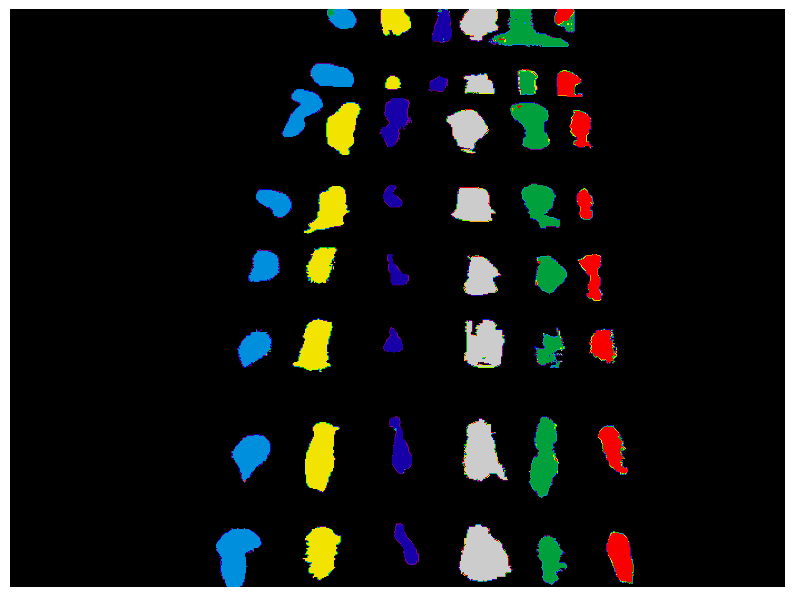

In [15]:
model = My_model(WS, k)
model.summary()
## Save Model Structure 
#file_name = str(HSID)+str(WS)+str(DLM)+str(k)+"_Hybrid_Without_Smoothing.png"
#plot_model(model, to_file = file_name, show_shapes=True, show_layer_names=True, dpi=500)
#files.download(file_name)
## Fit Model without Smoothing
model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
## Fit the Model
start = time.time()
history1 = model.fit(x = Tr, y = TrC, batch_size = batch_size, epochs = epochs, validation_data = (Va, VaC))
end = time.time()
Tr_Time = end - start
## Prediction Model
start = time.time()
Te_Pred = model.predict(Te)
end = time.time()
Te_Time = end - start
## Prediction and Computing the Accuacy
classification,confusion,oa,each_acc,aa,kappa,target_names = ClassificationReports(TeC,Te_Pred)
print(classification)
## Writing Results in CSV File
file_name = str(HSID)+str(WS)+str(DLM)+str(k)+"_Classification_Report_Without_Smoothing.csv"
CSV_file = CSVResults(file_name, classification, confusion, Tr_Time, Te_Time, DL_Time, kappa, oa, aa, each_acc)
# files.download(file_name)
## Predicted Ground Truths
outputs = GT_Plot(RDHSI, GT, model, WS)
file_name = str(HSID)+str(WS)+str(DLM)+str(k)+"_Ground_Truths__Without_Smoothing.png"
plt.figure(figsize=(10, 10))
plt.imshow(outputs, cmap='nipy_spectral')
# plt.colorbar()
plt.axis('off')
plt.savefig(file_name, dpi=500)
# files.download(file_name)

# **Model with Smoothing**

Epoch 1/10
265/265 [==============================] - 2s 5ms/step - loss: 0.3076 - accuracy: 0.9686 - val_loss: 0.2685 - val_accuracy: 0.9928
Epoch 2/10
265/265 [==============================] - 1s 4ms/step - loss: 0.2808 - accuracy: 0.9895 - val_loss: 0.2654 - val_accuracy: 0.9950
Epoch 3/10
265/265 [==============================] - 1s 4ms/step - loss: 0.2765 - accuracy: 0.9924 - val_loss: 0.2638 - val_accuracy: 0.9946
Epoch 4/10
265/265 [==============================] - 1s 4ms/step - loss: 0.2738 - accuracy: 0.9931 - val_loss: 0.2632 - val_accuracy: 0.9979
Epoch 5/10
265/265 [==============================] - 1s 4ms/step - loss: 0.2722 - accuracy: 0.9941 - val_loss: 0.2641 - val_accuracy: 0.9953
Epoch 6/10
265/265 [==============================] - 1s 4ms/step - loss: 0.2706 - accuracy: 0.9960 - val_loss: 0.2614 - val_accuracy: 0.9961
Epoch 7/10
265/265 [==============================] - 1s 4ms/step - loss: 0.2704 - accuracy: 0.9946 - val_loss: 0.2640 - val_accuracy: 0.9935
Epoch 

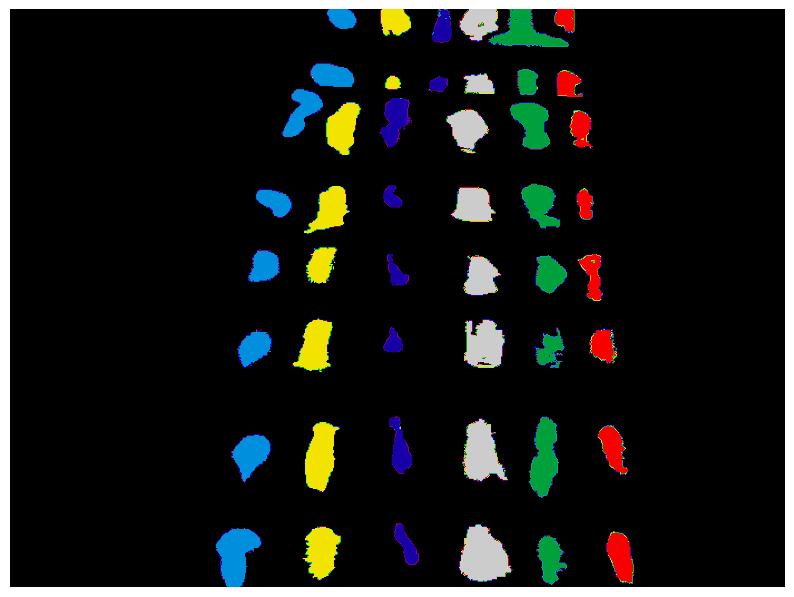

In [16]:
#model = My_model(WS, k)
model.compile(loss = Smoothing, optimizer = adam, metrics = ['accuracy'])
## Fit the Model
start = time.time()
history2 = model.fit(x = Tr, y = TrC1, batch_size = batch_size, epochs = epochs, validation_data = (Va, VaC1))
end = time.time()
Tr_Time = end - start
## Prediction Model
start = time.time()
Te_Pred = model.predict(Te)
end = time.time()
Te_Time = end - start
## Prediction and Computing the Accuacy
classification,confusion,oa,each_acc,aa,kappa,target_names = ClassificationReports(TeC1,Te_Pred)
print(classification)
## Writing Results in CSV File
file_name = str(HSID)+str(WS)+str(DLM)+str(k)+"_Classification_Report_With_Smoothing.csv"
CSV_file = CSVResults(file_name, classification, confusion, Tr_Time, Te_Time, DL_Time, kappa, oa, aa, each_acc)
# files.download(file_name)
## Predicted Ground Truths
outputs = GT_Plot(RDHSI, GT, model, WS)
file_name = str(HSID)+str(WS)+str(DLM)+str(k)+"_Ground_Truths__With_Smoothing.png"
plt.figure(figsize=(10, 10))
plt.imshow(outputs, cmap='nipy_spectral')
# plt.colorbar()
plt.axis('off')
plt.savefig(file_name, dpi=500)
# files.download(file_name)

# **3D CNN** for Comparison

In [17]:
## 3D CNN Model
input_layer = Input((WS, WS, k, 1))
conv_layer1 = Conv3D(filters=8, kernel_size=(3, 3, 7), activation='relu')(input_layer)
conv_layer2 = Conv3D(filters=16, kernel_size=(3, 3, 5), activation='relu')(conv_layer1)
conv_layer3 = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu')(conv_layer2)
conv_layer4 = Conv3D(filters=64, kernel_size=(3, 3, 3), activation='relu')(conv_layer3)
flatten_layer = Flatten()(conv_layer4)
dense_layer1 = Dense(units=256, activation='relu')(flatten_layer)
dense_layer1 = Dropout(0.4)(dense_layer1)
dense_layer2 = Dense(units=128, activation='relu')(dense_layer1)
dense_layer2 = Dropout(0.4)(dense_layer2)
output_layer = Dense(units=Num_Classes, activation='softmax')(dense_layer2)
model = Model(inputs=input_layer, outputs=output_layer)
model.summary()
# compiling the model
model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
## Fit Model
start = time.time()
history_3D_CNN = model.fit(x = Tr, y = TrC, batch_size = batch_size, epochs = epochs, validation_data = (Va, VaC))
end = time.time()
Tr_Time = end - start
## Prediction Model
start = time.time()
Te_Pred = model.predict(Te)
end = time.time()
Te_Time = end - start
## Computing the Accuacy
classification,confusion,oa,each_acc,aa,kappa,target_names = ClassificationReports(TeC, Te_Pred)
print(classification)
## Writing Results in CSV File
file_name = str(HSID)+str(WS)+str(DLM)+str(k)+"_classification_report_3D.csv"
CSV_file = CSVResults(file_name, classification, confusion, Tr_Time, Te_Time, DL_Time, kappa, oa, aa, each_acc)
files.download(file_name)
## Predicted Ground Truths
outputs = GT_Plot(RDHSI, GT, model, WS)
file_name = str(HSID)+str(WS)+str(DLM)+str(k)+"_Ground_Truths_3D_CNN.png"
plt.figure(figsize=(10, 10))
plt.imshow(outputs, cmap='nipy_spectral')
#plt.colorbar()
plt.axis('off')
plt.savefig(file_name, dpi=500)
files.download(file_name)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 9, 9, 15, 1)]     0         
                                                                 
 conv3d_2 (Conv3D)           (None, 7, 7, 9, 8)        512       
                                                                 
 conv3d_3 (Conv3D)           (None, 5, 5, 5, 16)       5776      
                                                                 
 conv3d_4 (Conv3D)           (None, 3, 3, 3, 32)       13856     
                                                                 
 conv3d_5 (Conv3D)           (None, 1, 1, 1, 64)       55360     
                                                                 
 flatten_1 (Flatten)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 256)               1664

NameError: name 'files' is not defined